In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, to_timestamp, year, month, count, sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from mpl_toolkits.mplot3d import Axes3D
import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster


spark = SparkSession.builder.master("local[*]").appName("practiceML").getOrCreate()
spark

DATA CLEANSING / PREPROCESSING

In [33]:
fire_incidents = spark.read.csv("FireIncidents.data.csv", header=True, inferSchema=True)
fire_incidents = fire_incidents.drop(fire_incidents.Business_Impact, fire_incidents.Ext_agent_app_or_defer_time, fire_incidents.Extent_Of_Fire, fire_incidents.Fire_Alarm_System_Impact_on_Evacuation,fire_incidents.Fire_Alarm_System_Operation, fire_incidents.Fire_Alarm_System_Presence, fire_incidents.Fire_Under_Control_Time, fire_incidents.Ignition_Source,fire_incidents.Incident_Station_Area, fire_incidents.Incident_Ward, fire_incidents.Material_First_Ignited, fire_incidents.Property_Use, fire_incidents.Method_Of_Fire_Control, fire_incidents.Smoke_Alarm_at_Fire_Origin_Alarm_Failure, fire_incidents.Smoke_Alarm_at_Fire_Origin_Alarm_Type, fire_incidents.Status_of_Fire_On_Arrival, fire_incidents.Last_TFS_Unit_Clear_Time,fire_incidents.TFS_Alarm_Time)
fire_incidents = fire_incidents.na.drop()
fire_incidents = fire_incidents.filter(fire_incidents.Possible_Cause != "Under Investigation")
fire_incidents = fire_incidents.withColumn("TFS_Arrival_Time", to_timestamp(col("TFS_Arrival_Time")))
fire_incidents.show(truncate=False, n=100000)
# fire_incidents.printSchema()

root
 |-- Area_of_Origin: string (nullable = true)
 |-- Civilian_Casualties: integer (nullable = true)
 |-- Count_of_Persons_Rescued: integer (nullable = true)
 |-- Estimated_Dollar_Loss: integer (nullable = true)
 |-- Estimated_Number_Of_Persons_Displaced: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Possible_Cause: string (nullable = true)
 |-- TFS_Arrival_Time: timestamp (nullable = true)



In [34]:
# Agregasi data berdasarkan Latitude dan Longitude untuk menghitung jumlah kejadian kebakaran
agg_df = fire_incidents.groupBy("Latitude", "Longitude").count()

# Konversi ke Pandas DataFrame
agg_pd_df = agg_df.toPandas()

# Buat peta
m = folium.Map(location=[agg_pd_df['Latitude'].mean(), agg_pd_df['Longitude'].mean()], zoom_start=12)

# Buat MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Tambahkan data ke MarkerCluster
for _, row in agg_pd_df.iterrows():
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=f"Count: {row['count']}"
    ).add_to(marker_cluster)

# Simpan peta ke file HTML
m.save('fire_incidents_map.html')


1. MENGANALISIS BERAPA RATA-RATA KERUGIAN(DOLLAR) BERDASARKAN AREA KEBAKARAN DAN PENYEBAB KEBAKARAN (start)

In [35]:
avg_loss_by_area = fire_incidents.groupBy("Area_of_origin").agg(avg("Estimated_Dollar_Loss").alias("Avg_Dollar_Loss"))
avg_loss_by_area.show(truncate=False)

+----------------------------------------------------------------+------------------+
|Area_of_origin                                                  |Avg_Dollar_Loss   |
+----------------------------------------------------------------+------------------+
|Elevator (includes shaft)                                       |12165.130434782608|
|Trash, Rubbish Storage (inc garbage chute room, garbage/industri|4411.051930758988 |
|Supply Storage Room (inc maintenance/office/document storage, et|28994.444444444445|
|Cooking Area or Kitchen                                         |19716.00941422594 |
|Other Vehicle Area                                              |80240.0           |
|Mechanical/Electrical Services Room                             |50233.846153846156|
|Residential/Business: Other busines area                        |191208.33333333334|
|Other Building Services/Support Facilities                      |3331.5789473684213|
|Electronic Equipment                                 

In [36]:
avg_loss_by_cause = fire_incidents.groupBy("Possible_Cause").agg(avg("Estimated_Dollar_Loss").alias("Avg_Dollar_Loss"))
avg_loss_by_cause.show()

+--------------------+------------------+
|      Possible_Cause|   Avg_Dollar_Loss|
+--------------------+------------------+
|Children Playing ...|16189.774193548386|
|Other misuse of i...|  36836.7037037037|
|       Exposure fire| 70717.64705882352|
|Improperly Discarded|11111.723638869746|
|Vehicle Accident/...|          137670.0|
|  Mechanical Failure|51739.842307692306|
|Used for purpose ...| 11097.93220338983|
|    Improper Storage|18985.823529411766|
|Riot/Civil Commotion|              50.0|
|Other unintention...| 27897.21990521327|
|     Suspected Arson| 48596.61417322834|
|       Natural Cause| 44997.11538461538|
|Improper handling...| 19686.51113861386|
|Routine maintenan...|10297.630057803468|
|Unintentional, ca...|55612.936170212764|
|Used or Placed to...| 34280.61139896373|
|Suspected Youth V...|           12595.0|
|            Rekindle|            7091.0|
|Design/Constructi...| 25549.73033707865|
|        Undetermined| 99100.87651471437|
+--------------------+------------

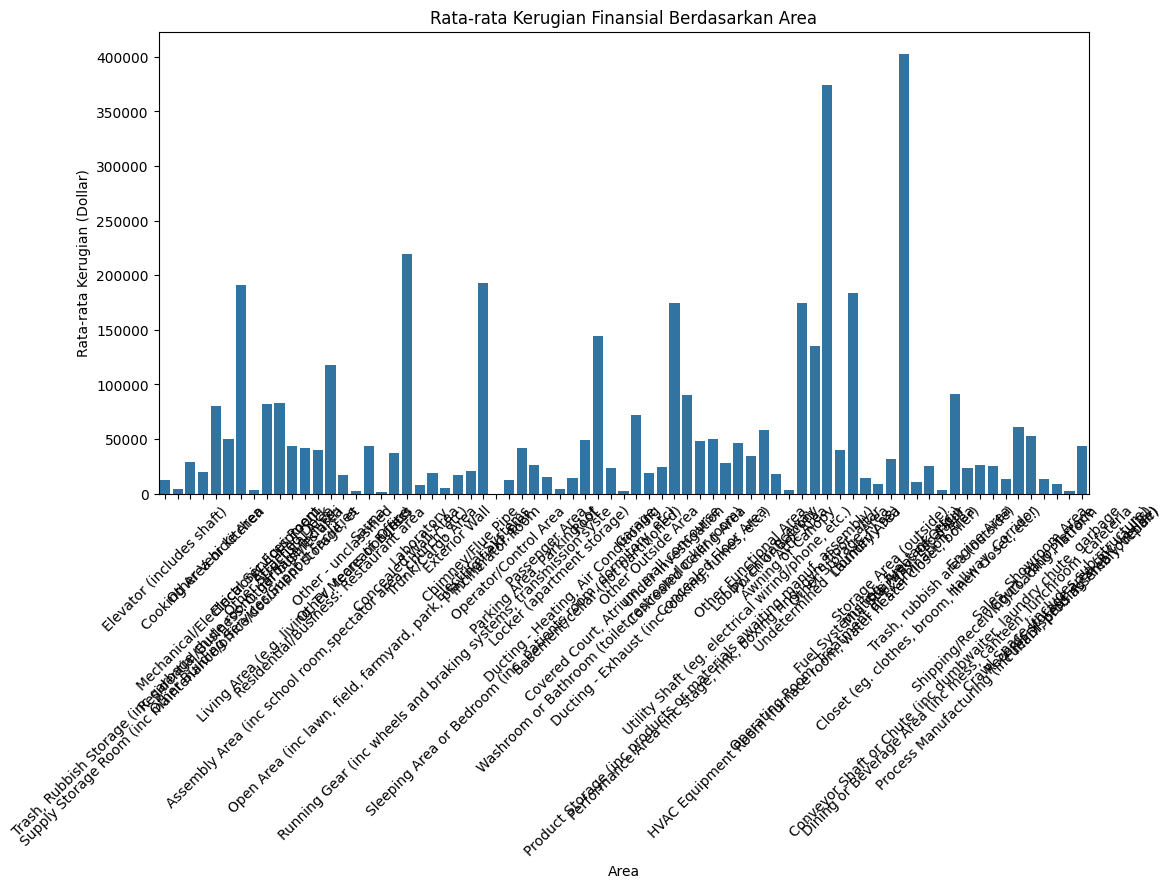

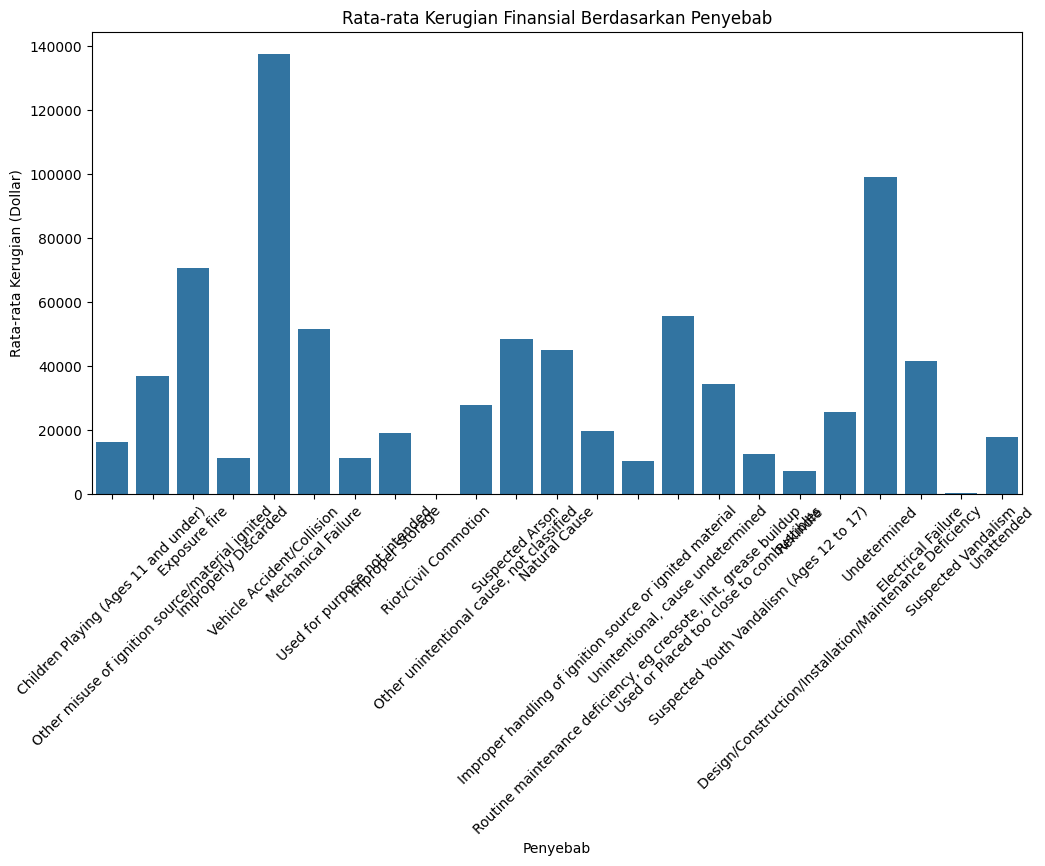

In [37]:
# Konversi ke Pandas DataFrame untuk visualisasi
avg_loss_by_area_pd = avg_loss_by_area.toPandas()
avg_loss_by_cause_pd = avg_loss_by_cause.toPandas()

# Plot Rata-rata kerugian berdasarkan Incident_Area
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_loss_by_area_pd, x="Area_of_origin", y="Avg_Dollar_Loss")
plt.title("Rata-rata Kerugian Finansial Berdasarkan Area")
plt.xlabel("Area")
plt.ylabel("Rata-rata Kerugian (Dollar)")
plt.xticks(rotation=45)
plt.show()

# Plot Rata-rata kerugian berdasarkan Possible_Cause
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_loss_by_cause_pd, x="Possible_Cause", y="Avg_Dollar_Loss")
plt.title("Rata-rata Kerugian Finansial Berdasarkan Penyebab")
plt.xlabel("Penyebab")
plt.ylabel("Rata-rata Kerugian (Dollar)")
plt.xticks(rotation=45)
plt.show()


1. MENGANALISIS BERAPA RATA-RATA KERUGIAN(DOLLAR) BERDASARKAN AREA KEBAKARAN DAN PENYEBAB KEBAKARAN (end)

2. MENGIDENTIFIKASI TREN ATAU POLA DARI TAHUN KE TAHUN UNTUK MENGANALISIS JUMLAH KEBAKARAN DAN KORBAN JIWA (start)

In [38]:
df_trend = fire_incidents.withColumn("Year", year(col("TFS_Arrival_Time"))) \
             .withColumn("Month", month(col("TFS_Arrival_Time"))) \
             .groupBy("Year", "Month") \
             .agg(
                 count("TFS_Arrival_Time").alias("Incident_Count"),
                 sum("Civilian_Casualties").alias("Total_Civilian_Casualties"),
                 sum("Count_of_Persons_Rescued").alias("Total_Persons_Rescued"),
                 sum("Estimated_Dollar_Loss").alias("Total_Estimated_Dollar_Loss"),
                 sum("Estimated_Number_Of_Persons_Displaced").alias("Total_Persons_Displaced")
             ) \
             .orderBy("Year", "Month")

# Tampilkan hasil agregasi
df_trend.show(10000)

+----+-----+--------------+-------------------------+---------------------+---------------------------+-----------------------+
|Year|Month|Incident_Count|Total_Civilian_Casualties|Total_Persons_Rescued|Total_Estimated_Dollar_Loss|Total_Persons_Displaced|
+----+-----+--------------+-------------------------+---------------------+---------------------------+-----------------------+
|2011|    1|           100|                        2|                    7|                    4011731|                   1124|
|2011|    2|           102|                       12|                   15|                    2947401|                   4410|
|2011|    3|           124|                        7|                    1|                   15018055|                   1247|
|2011|    4|            98|                        4|                    7|                    2941385|                   1825|
|2011|    5|           105|                       10|                    1|                    3841760| 

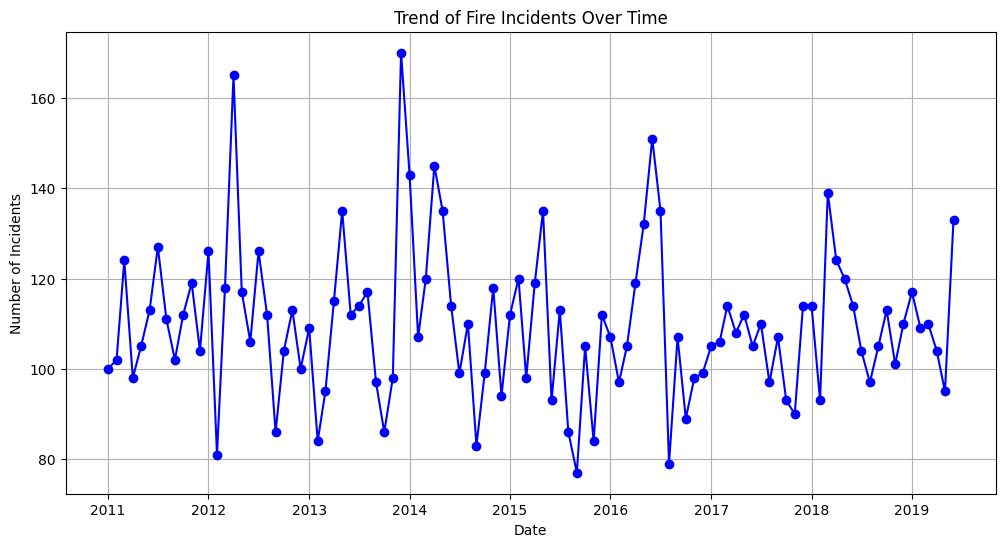

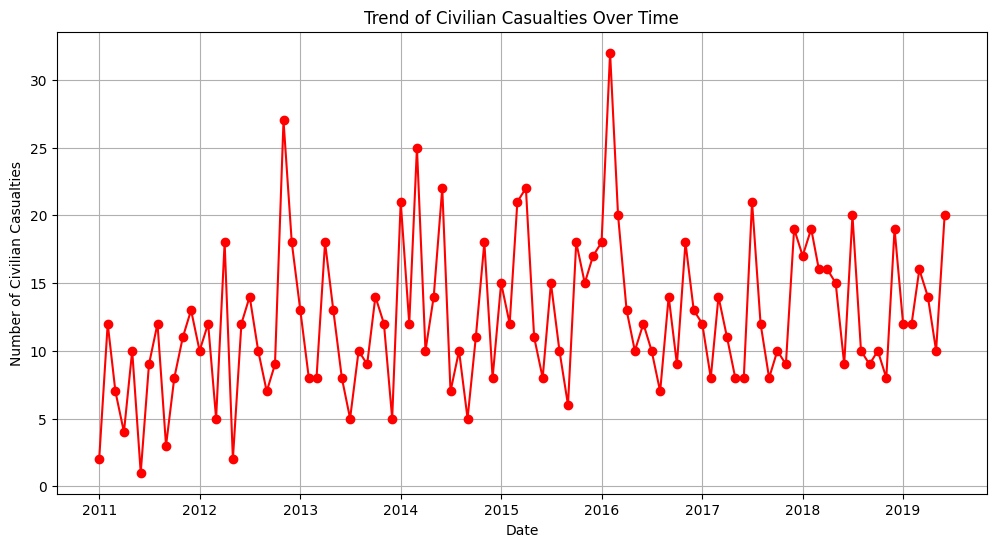

In [39]:
# Konversi DataFrame PySpark ke Pandas DataFrame
pd_df_trend = df_trend.toPandas()

# Buat kolom datetime dari Year dan Month untuk memudahkan plotting
pd_df_trend['Date'] = pd.to_datetime(pd_df_trend[['Year', 'Month']].assign(DAY=1))

# Plotting tren insiden kebakaran
plt.figure(figsize=(12, 6))
plt.plot(pd_df_trend['Date'], pd_df_trend['Incident_Count'], marker='o', linestyle='-', color='b')
plt.title('Trend of Fire Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

# Plotting tren lainnya (misalnya, korban sipil)
plt.figure(figsize=(12, 6))
plt.plot(pd_df_trend['Date'], pd_df_trend['Total_Civilian_Casualties'], marker='o', linestyle='-', color='r')
plt.title('Trend of Civilian Casualties Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Civilian Casualties')
plt.grid(True)
plt.show()

2. MENGIDENTIFIKASI TREN ATAU POLA DARI TAHUN KE TAHUN UNTUK MENGANALISIS JUMLAH KEBAKARAN DAN KORBAN JIWA (end)

3. CLUSTERING MENGGUNAKAN K-MEANS (start)

In [40]:
assembler = VectorAssembler(inputCols=['Civilian_Casualties', 'Count_of_Persons_Rescued', 'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced'], 
                            outputCol="Attributes")

output = assembler.transform(fire_incidents)

model = KMeans(featuresCol='Attributes', k=4)

mycluster = model.fit(output)
print(mycluster)

prediction = mycluster.transform(output)
prediction.show(100, truncate=False)

KMeansModel: uid=KMeans_12434e45216f, k=4, distanceMeasure=euclidean, numFeatures=4
+----------------------------------------------------------------+-------------------+------------------------+---------------------+-------------------------------------+-----------+------------+--------------------------------------------------------+-------------------+--------------------------+----------+
|Area_of_Origin                                                  |Civilian_Casualties|Count_of_Persons_Rescued|Estimated_Dollar_Loss|Estimated_Number_Of_Persons_Displaced|Latitude   |Longitude   |Possible_Cause                                          |TFS_Arrival_Time   |Attributes                |prediction|
+----------------------------------------------------------------+-------------------+------------------------+---------------------+-------------------------------------+-----------+------------+--------------------------------------------------------+-------------------+-------------------

In [41]:
centers = mycluster.clusterCenters()
print("Cluster centers: ")
for center in centers:
    print(center)

Cluster centers: 
[1.08755005e-01 5.36039316e-02 1.96337803e+04 1.45070076e+01]
[0.00000000e+00 0.00000000e+00 7.11111111e+06 1.22333333e+02]
[1.05263158e-01 5.78947368e-01 2.07105263e+06 4.20736842e+02]
[3.33333333e-01 3.49206349e-01 5.91523810e+05 1.29021164e+02]


In [42]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='Attributes', metricName='silhouette')
silhouette = evaluator.evaluate(prediction)
print('Silhouette with squared euclidian distance = ' + str(silhouette))

Silhouette with squared euclidian distance = 0.9772925234383806


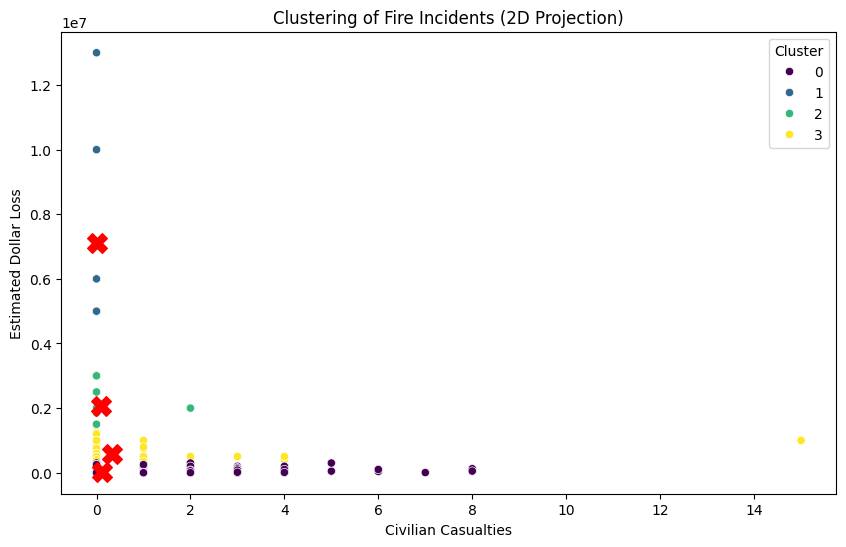

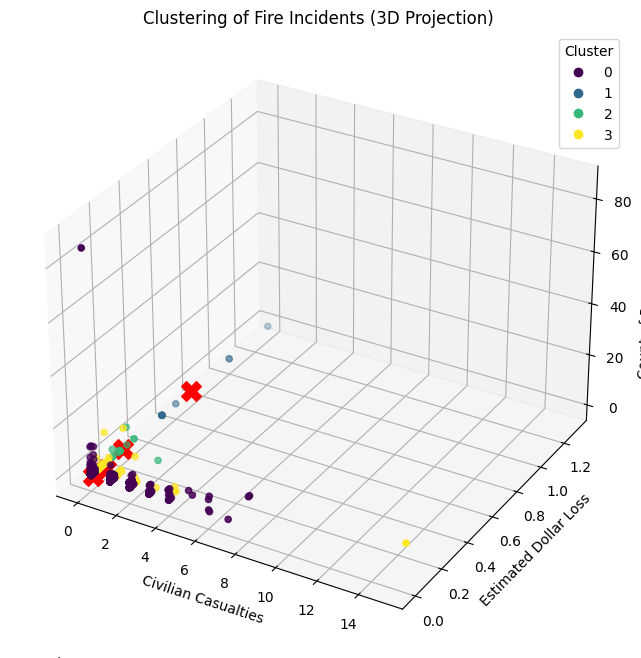

In [43]:
# Mengambil data prediksi dan mengonversinya ke dataframe pandas
prediction_df = prediction.select('Civilian_Casualties', 'Count_of_Persons_Rescued', 
                                  'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced', 
                                  'prediction').toPandas()

# Plotting dalam 2D (memilih dua fitur untuk representasi visual)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=prediction_df, x='Civilian_Casualties', y='Estimated_Dollar_Loss', hue='prediction', palette='viridis')
plt.scatter([center[0] for center in centers], [center[2] for center in centers], c='red', marker='X', s=200)
plt.title('Clustering of Fire Incidents (2D Projection)')
plt.xlabel('Civilian Casualties')
plt.ylabel('Estimated Dollar Loss')
plt.legend(title='Cluster')
plt.show()

# Plotting dalam 3D (jika ingin visualisasi 3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(prediction_df['Civilian_Casualties'], prediction_df['Estimated_Dollar_Loss'], prediction_df['Count_of_Persons_Rescued'], 
                     c=prediction_df['prediction'], cmap='viridis')

# Menandai pusat cluster
for center in centers:
    ax.scatter(center[0], center[2], center[1], c='red', marker='X', s=200)

ax.set_title('Clustering of Fire Incidents (3D Projection)')
ax.set_xlabel('Civilian Casualties')
ax.set_ylabel('Estimated Dollar Loss')
ax.set_zlabel('Count of Persons Rescued')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

3. CLUSTERING MENGGUNAKAN K-MEANS (end)